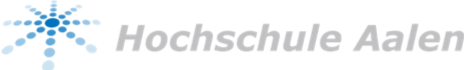


# Abschlussbericht Analyseprojekt "Google Reviews Mining"

    Text Mining und Web Analytics 
    Sommersemester 2023
    Christian Wilhelm

Laura Tatlik // Data Science und Business Analytics

<img src="images/Laura.jpg" width="300">

Bastian Rütters // Data Science und Business Analytics

<img src="images/Bastian.jpg" width="300">

Herbi Sinti // Data Science und Business Analytics

<img src="images/Herbi.jpg" width="300">

In [1]:
# NLP-Module
import spacy
from spacy.lang.de.stop_words import STOP_WORDS
nlp = spacy.load('de_core_news_md')
from wordcloud import WordCloud

# Module zur Datenbearbeitung und Visualisierung
import pandas as pd
pd.set_option('display.max_colwidth', None)
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
from collections import Counter

# Machine Learning Module
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# Sontige Module
import re
import string

OSError: [E050] Can't find model 'de_core_news_md'. It doesn't seem to be a Python package or a valid path to a data directory.

## Inhaltsverzeichnis

1 Einleitung<br>
2 CRISP-DM<br>
&nbsp;&nbsp;&nbsp;2.1 Business Understanding<br>
&nbsp;&nbsp;&nbsp;2.2 Data Preparation<br>
&nbsp;&nbsp;&nbsp;2.3 Data Understanding<br>
&nbsp;&nbsp;&nbsp;2.4 Modeling<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.4.1 Vorbereitungen<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.4.2 NLP-textcat_multilabel<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.4.3 Bewertung des Modell<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.4.4 Vorhersage der Bewertung<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.4.5 Bewertung des Ergebnis<br>
&nbsp;&nbsp;&nbsp;2.5 Evaluation<br>
&nbsp;&nbsp;&nbsp;2.6 Deployment<br>
3 Fazit

## 1 Einleitung

Dieser Bericht dient als Ergänzung zu der schriftlichen Ausarbeitung um vor allem den geschriebenen Code in diesem Projekt gut veranschaulichen zu können.

## 2 CRISP-DM
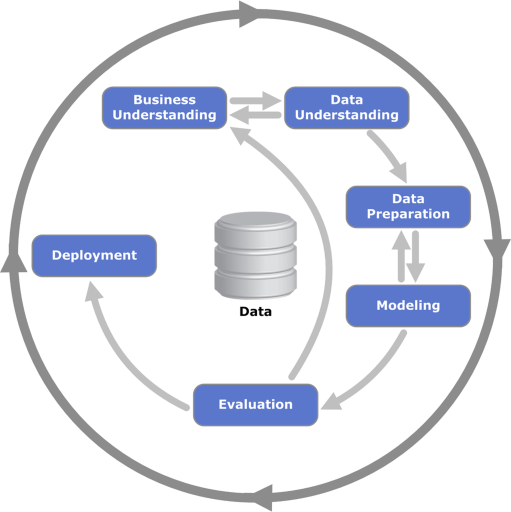

### 2.1 Business Understanding
Nahezu jeder hat sich in Zeiten der Digitalisierung bei der Suche nach einem geeigneten Restaurant oder Lieferdienst, bereits an den Bewertungen im Internet anderer Kunden bedient und anschließend darauf eine Entscheidung für oder gegen eine mögliche Location entschieden. Ob nach der Entscheidung aber genau die eigenen Bedürfnisse entsprechend befriedigt werden, bleibt offen bis zur eigenen Erfahrung. Im folgenden Jupyter Notebook wird die Herangehensweise und Methodik anhand von Code, Codekommentaren und Markdown-Felder erkläutert.

<img src="images/Project_Canvas.jpg" width="1000">

### 2.2 Data Preparation
Die Phase der Datenvorbereitung umfasst alle Aktivitäten zur Erstellung des endgültigen Datensatzes oder der Daten, die aus den anfänglichen Rohdaten in das Modell eingespeist werden. Zu den Aufgaben gehören die Auswahl von Tabellen, Datensätzen und Attributen sowie die Umwandlung und Bereinigung von Daten für das Modell [1].

Die Rohdaten für dieses Projekt werden durch den Scraper (../scrapper/GoogleReviewScrapper.ipynb) von Google Maps extrahiert und als csv-Datei in ../data/reviews.csv gespeichert.

Gescrapt wurden die Bewertungen von 3 Restauraunts/Imbissbuden:

- Super Bros: Pizzaria in Frankfurt am Main
- Dene Gör: Dönerladen in Düsseldorf
- Space Burger: Burgerladen in Düsseldorf

In [ ]:
# Einlesen der gescrapten Daten
df = pd.read_csv('data/reviews.csv', sep=';')

In [ ]:
# Entfernen aller Datenpunkte mit NaN
df = df.loc[~df['caption'].isnull(), ['caption', 'rating', 'timestamp']]

# Indexspalte entfernen
df.reset_index(drop=True)

# Übersicht über bearbeiteten Dataframe
df.head(3)

In [ ]:
# Translated by Google aus den Bewertungen entfernen
df['caption'] = df['caption'].str.split('(Translated by Google)').str[0]

# Übersicht über bearbeiteten Dataframe
df.head(3)

In [ ]:
# Übersicht über Stop-Words in der deutschen Sprache
print(STOP_WORDS)

In [ ]:
# HERBI - BITTE kurz erläutern was in der Funktion passiert und 
# Kommentare innerhalb der Funktion auf deutsch ändern
REGX_USERNAME = r"@[A-Za-z0-9$-_@.&+]+"
REGX_URL = r"https?://[A-Za-z0-9./]+"
def preprocessing(text):
    text = text.lower()

    # Remove
    text = re.sub(REGX_USERNAME, ' ', text)
    text = re.sub(REGX_URL, ' ', text)

    # Replace Emojis
    emojis = {
        ':)': 'positive emotionen',
        ':(': 'negative emotionen'
    }

    for e in emojis:
        text = text.replace(e, emojis[e])

    tokens = [token.text for token in nlp(text)]

    # Remove Stop Words, punctuations and words with less than 3 characters
    tokens = [t for t in tokens if
              t not in STOP_WORDS and
              t not in string.punctuation and
              len(t) > 3]

    tokens = [t for t in tokens if not t.isdigit()]

    text = " ".join(tokens);

    # Lemmatization
    allowed_postags = ["NOUN", "ADJ", "VERB", "ADV"]
    doc = nlp(text)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    lemmatized = " ".join(new_text).lower()

    return lemmatized

df["caption_clean"] = df["caption"].apply(preprocessing)
df[['caption', 'caption_clean', 'rating']].head()

In [ ]:
# Neu benennung der Spalten und Auswahl der bearbeiteten Spalten
df = df[['caption_clean', 'rating', 'timestamp']]
df = df.rename(columns={"caption_clean": "caption"})
df.reset_index(drop=True)

In [ ]:
# Erneutes löschen der NaN Werte in bearbeiteten Spalten
df = df.loc[~df['caption'].isnull(), ['caption', 'rating', 'timestamp']]
df = df[df['caption'].str.strip().astype(bool)]

In [ ]:
# Übersicht über die Spalte mit den Bewertungen
df['caption']

In [ ]:
# Dataframe als csv-Datei abspeichern
df.to_csv('data/reviews-clean.csv', sep=';')

### 2.3 Data Understanding
Die zweite Phase im CIRSP-DM Model, das Data Understanding, ist der Schritt, in dem man Daten aus verschiedenen Quellen sammelt, aufbereitet, untersucht, relevante Daten für die Analyse auswählt, Datenziele anpasst, mögliche Datenprobleme identifiziert und ein besseres Verständnis der Daten erhält, um fundierte Entscheidungen für die weitere Analyse treffen zu können [1].

In [ ]:
# Relativen Pfad definieren
REVIEWS_CLEANED_FILE_PATH = 'data/labeled_data_cleaned.csv'

# Einlesen der bearbeiteten Daten
df = pd.read_csv(REVIEWS_CLEANED_FILE_PATH, sep=';')

In [ ]:
# Alle Bewertungen in einen langen String joinen
full_caption_text = '. '.join(df['caption'])
len(full_caption_text)

In [ ]:
# Funktion um die meist genutzten Wörter zu ermitteln
def getWordFrequency(text, pos="NOUN", top_items=0):
    doc = nlp(text)
    words = [token.lemma_
             for token in doc
             if (not token.is_stop and not token.is_punct and (pos == "" or token.pos_ == pos))]
    word_freq = Counter(words)

    return(dict(word_freq.most_common(top_items) if top_items else word_freq.most_common()))

In [ ]:
# Axen initialisieren
f, ax = plt.subplots(1,1)
# Ermitteln der Anzahl der Sterne-Bewertungen
ratings = df['rating'].value_counts().reset_index()
# Spalten definieren
ratings.columns = ['rating', 'count']
# Abstiegend sortieren
ratings = ratings.sort_values(by=['rating'], ascending=False)
# Barplot erstellen
sns.barplot(ratings, x="rating", y='count', color='b', ax=ax)
#ax.set(xlabel='Bewertung', ylabel='Zahl')

In [ ]:
# Funktionszuweisung - freq
freq = getWordFrequency(full_caption_text, "NOUN")

In [ ]:
# WordCloud-Diagramm der am häufigsten verwendeten Wörter erstellen
plt.figure(figsize=(15, 12), facecolor = None)
plt.imshow(WordCloud(width = 800, height = 400,
                     background_color='white').generate( full_caption_text ))
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('meistverwendete Wörter', fontsize=23, fontweight='bold')
plt.show()

In [ ]:
# Erstellung meistverwendeten Nomen und Verben
freqNoun = getWordFrequency(full_caption_text, "NOUN")
freqVerb = getWordFrequency(full_caption_text, "VERB")

# Erstellung der Variablen "freqs" und "titles", um die Häufigkeit von Nomen und Verben darzustellen.
freqs = [freqNoun, freqVerb]
titles = ['meistverwendete Nomen', 'meistverwendete Verben']

# WordCloud-Diagramm mit 2 Subplots
f, axes = plt.subplots(1,2)
f.set_figheight(15)
f.set_figwidth(20)
for i, ax in enumerate(axes):
    ax.imshow(WordCloud(width = 800, height = 800,
                        background_color='white').generate_from_frequencies( freqs[i] ))
    ax.axis('off')
    ax.set_title(titles[i], fontsize=18, fontweight='bold')

In [ ]:
# Bewertungen der jeweiligen Sterne-Kategorien in String-Format joinen
full_caption_text_1 = '. '.join(df.loc[df['rating'] == 1]['caption'])
full_caption_text_2 = '. '.join(df.loc[df['rating'] == 2]['caption'])
full_caption_text_3 = '. '.join(df.loc[df['rating'] == 3]['caption'])
full_caption_text_4 = '. '.join(df.loc[df['rating'] == 4]['caption'])
full_caption_text_5 = '. '.join(df.loc[df['rating'] == 5]['caption'])

In [ ]:
# Berechnung der Häufigkeit von Adjektiven im Text mit 5 und 4 Sternen Bewertung
freqs1 = [ getWordFrequency(full_caption_text_5, "ADJ"),
           getWordFrequency(full_caption_text_4, "ADJ")]

# Berechnung der Häufigkeit von Adjektiven im Text mit 3, 2 und 1 Sternen Bewertung
freqs2 = [getWordFrequency(full_caption_text_3, "ADJ"),
          getWordFrequency(full_caption_text_2, "ADJ"),
          getWordFrequency(full_caption_text_1, "ADJ")]

# Titel für das Wordcloud-Diagramm
titles1 = ['5 Sterne', '4 Sterne']
titles2 = ['3 Sterne', '2 Sterne', '1 Stern']

# Erstellung von zwei Subplots mit einer Spalte und zwei bzw. drei Zeilen.
f1, axes1 = plt.subplots(1, 2)
f2, axes2 = plt.subplots(1, 3)

# Plotgröße ändern
f1.set_figheight(15)
f1.set_figwidth(20)

# Plotgröße ändern
f2.set_figheight(15)
f2.set_figwidth(20)

# Erstellung der WordCloud-Diagramme für Texte mit 5 und 4 Sterne Bewertung
for i, ax in enumerate(axes1):
    ax.imshow(WordCloud(width = 300, height = 300,
                        background_color='white').generate_from_frequencies( freqs1[i] ))
    ax.axis('off')
    ax.set_title(titles1[i], fontsize=18, fontweight='bold')

# Erstellung der WordCloud-Diagramme für Texte mit 3, 2 und 1 Sterne Bewertung
for i, ax in enumerate(axes2):
    ax.imshow(WordCloud(width = 300, height = 300,
                        background_color='white').generate_from_frequencies( freqs2[i] ))
    ax.axis('off')
    ax.set_title(titles2[i], fontsize=18, fontweight='bold')

### 2.4 Modeling
In der vierten Phase des CRISP-DM Modell, dem Modeling, werden verschiedene Modellierungstechniken evaluiert. Es wird überprüft, welche Technik für das jeweilige Data-Mining-Problem am besten anwendbar ist. Hier müssen gegebenenfalls die Schritte der Datenvorbereitung wiederholt werden. Neben der Auswahl der Modellierungstechnik und der eigentlichen Modellierung wird oder werden die Modelle am Ende dieser Phase ebenfalls nach verschiedenen Kriterien bewertet und in den Kontext des Data-Mining-Problems eingeordnet [1].

Für die spätere Bewertung werden bei Klassifizierungsproblemen, wie dies, welches in diesem Projekt vorliegt, Fehlerraten als Qualitätsmaßstab genutzt. Um eine verzerrungsfreie Evaluierung sicherstellen zu können, müssen die Daten in ein Trainings- und einem Testdatensatz getrennt werden. Die Modellierung beruht dann auf dem Trainingsdatensatz und wird mithilfe des Testdatensatzes die Qualität der Vorhersage geschätzt [1].

#### 2.4.1 NLP-TfidfVectorizer

In [2]:
# Selbsterstellte Bewertungen mit label
trainingsdata = pd.read_csv("/Users/bastian/Documents/HS Aalen/Trimester 6/Text Mining und Web Analytics/NLPGoogleReviewSummary/data/reviews_merged_cleaned.csv", sep=';')

Die gesäuberten Daten wurden manuell mit den verschiedenen Kategorien gelabelt.

In [3]:
trainingsdata.iloc[:,1:].head()

,food_positive,service_positive,ambient_positive,price_positive,waiting_positive,rating,caption
0,1,0,0,0,0,4.0,mega cooles ambiente konzept bürger geschmackl...
1,1,1,1,0,0,5.0,super sympathische mitarbeiter freundliche gem...
2,1,0,1,0,0,5.0,nenne burger schicki-micki gerne burgerladen d...
3,0,0,0,0,0,1.0,gestern dritt selben burger bestellt gestern a...
4,1,0,1,0,0,4.0,fanden burger restaurant klasse individuelle m...


In [4]:
def nlp_tfidfvectorizer(data, category, text):
    
    subset_train = data[['caption', category]]
    train_data = list(subset_train.itertuples(index=False, name=None))
    
    # Trainingsdaten (Beispiele von Texten, die manuell in die verschiedenen Kategorien eingeteilt wurden)
    training_data = trainingsdata
    
    # Pipeline, die aus einem TfidfVectorizer und einem LinearSVC-Modell besteht
    model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('svc', LinearSVC())
    ])

    # Trainiere das Modell auf den Trainingsdaten
    model.fit([text for text, category in training_data], [category for text, category in training_data])

    # Verwende das trainierte Modell, um eine neue Kategorie für einen gegebenen Text vorherzusagen
    predicted_category = model.predict([text])
    
    return predicted_category[0] if predicted_category else 0

In obiger Funktion wird eine Pipeline erstellt, die einen Text in ein maschinenlesbares Format umwandelt und dann eine lineare SVM verwendet, um die Textdaten zu klassifizieren. Die Intention dieser Funktion ist eine automatische Zuordnung von Texten zu bestimmten Kategorien auf der Grundlage eines trainierten Modells.

In [23]:
# Vorhersagen für die Kategorie Essen
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'food_positive', 'Das Essen war gut')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'food_positive', 'Es hat nicht geschmeckt')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'food_positive', 'Schlechtes Essen')}")
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'food_positive', 'Es war köstlich')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'food_positive', 'Es war schlimm')}")
print("...")

print(f"\nAccuracy: {3/5}%, jedoch Tendenz zur Vorhersage der Kategorie 1, da Overfitting der Trainingsdaten\nEbenso wurden keine komplexen Satzstellung als Input verwendet")

Actually: 1, Predictet: 1
Actually: 0, Predictet: 0
Actually: 0, Predictet: 1
Actually: 1, Predictet: 1
Actually: 0, Predictet: 1
...

Accuracy: 0.6%, jedoch Tendenz zur Vorhersage der Kategorie 1, da Overfitting der Trainingsdaten
Ebenso wurden keine komplexen Satzstellung als Input verwendet


In [21]:
# Vorhersagen für die Kategorie Service
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'service_positive', 'Super freundlich')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'service_positive', 'Unfreundliche Bedienung')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'service_positive', 'Die Bedienung war sehr unfreundlich')}")
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'service_positive', 'Die Bedienung war sehr freundlich')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'service_positive', 'Das Essen war sehr lecker, doch die Bedienung war nicht freundlich')}")
print("...")

print(f"\nAccuracy: {4/5}%, jedoch nicht Aussagekräftig, da keine komplexen Satzstellungen als Input verwendet wurden")

Actually: 1, Predictet: 1
Actually: 0, Predictet: 0
Actually: 0, Predictet: 0
Actually: 1, Predictet: 1
Actually: 0, Predictet: 1
...

Accuracy: 0.8%, jedoch nicht Aussagekräftig, da keine komplexen Satzstellungen als Input verwendet wurden


In [20]:
# Vorhersagen für die Kategorie Ambiente
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'ambient_positive', 'Schönes Ambiente')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'ambient_positive', 'Kein schönes Ambiente')}")
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'ambient_positive', 'Das Ambiente war schön')}")
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'ambient_positive', 'Wir haben uns sehr wohl gefühlt')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'ambient_positive', 'Das Essen war sehr lecker, doch das Ambiente war nicht schön')}")
print("...")

print(f"\nAccuracy: {2/5}%, Anwendung komplexerer Satzstellungen --> Resultiert in schlechterer Genauigkeit")

Actually: 1, Predictet: 1
Actually: 0, Predictet: 1
Actually: 1, Predictet: 1
Actually: 1, Predictet: 0
Actually: 0, Predictet: 1
...

Accuracy: 0.4%, Anwendung komplexerer Satzstellungen --> Resultiert in schlechterer Genauigkeit


Es ist festzustellen, dass der Umfang des Trainingsdatensatzes zu gering ist um eine gute Vorhersage eines Textes zu erzeugen. Die Vorhersagen in den Unterschiedlichen Kategorien sind vielversprechend, wenn der Text aus wenigen Wörtern besteht und nicht Teil eines komplexen Satzes ist. Aufgrund dessen wird dieser Ansatz verworfen und im nächsten Abschnitt ein Model implementiert, welches die Bewertungen selbst labeln kann. 

#### 2.4.2 Vorbereitungen NLP-textcat_multilabel
Hier Text über Vorbereitung

#### 2.4.3 NLP-textcat_multilabel

#### 2.4.4 Bewertung des Models


#### 2.4.5 Vorhersage der Bewertung
Nachdem die gescrapten Bewertungen mithilfe des Models gelabelt wurden, dienen diese Daten nun als Trainingsdaten für eine multiple lineare Regression.

Zur Vorhersage wird dann der Input bla bla bla

In [ ]:
# Dataframe der maschinell gelabelten Daten einlesen
labeld_data = pd.read_csv() # Gelabelte Daten von Textcat Modell

In [ ]:
# Benötigte Spalte definieren --- noch benötigt?
data_predict = labeld_data.iloc[:, 2:]

In [ ]:
# Prädiktoren und Zielvariable definieren
X = data_predict.iloc[:, :-1]
y = data_predict.iloc[:, -1:]

In [ ]:
# NaN-Werte mit 0 füllen
X.fillna(0, inplace=True)

In [ ]:
# Datensatz in Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

In [ ]:
# Lineare Regressionsmodell initialisieren
model = LinearRegression()

In [ ]:
# Model auf die Trainingsdaten fitten
model.fit(X_train, y_train)

In [ ]:
# Vorhersagen treffen
predicitions = model.predict(X_test)

In [ ]:
# Evaluation des Modells

In [ ]:
# Eingabe der gewünschten Kategorien und Vorhersage der neuen Bewertung
neue_bewertung = model.predict(np.array([]).reshape(1, -1)) # Array mit 1/0 je Kategorie übergeben

In [ ]:
# Neue Bewertung gemäß der gewünschten Kriterien
print(round(neue_bewertung[0][0], 2))

#### 2.4.5 Bewertung der Ergebnis


### 2.5 Evaluation
Bei der Phase der Evaluation wird überprüft, ob die Zielsetzung des Data-Mining-Projekts erreicht wurde. Hierbei werden die Resultate der Modellierung und das Vorgehen bzw. der Prozess der Informationsgewinnung bewertet. Falls das Ergebnis hier deutlich negativ ausfällt, ist zu überprüfen, ob es gegebenenfalls einen erneuten Durchlauf des CRISP-DM-Modells benötigt. Zum Schluss werden die nächsten Schritte bzw. die Schritte für as Deployment festgelegt [1].

HIER EVALUATION ÜBER MODELL

### 2.6 Deployment
Im Folgenden wird das Deployment des zuvor entwickeltend Modells beschrieben. Aus Zeit- und Komplexitätsgründen wurde die folgenden Schritte und Maßnahmen nicht im Rahmen des Projekts umgesetzt.

## 3 Fazit
Die Vorhersage von Ergebnissen in sportlichen Wettkämpfen ist eine äußerst schwierige Sache. Die in diesem Projekt verwendeten Prädiktoren können zwar Ergebnisse vorhersagen, die Wahrscheinlichkeit liegt hier abgerundet dennoch nur bei 50 zu 50. Diese 50/50 Chance ist jedoch besser als die im Projekt genannte Wahrscheinlichkeit, wenn allen Spielen zufällige Ergebnisse vorhergesagt werden. Eine präzisere Vorhersage wäre durch das Einbeziehen neuer Prädiktoren wie Anzahl der Zuschauer, dem Wetter einzelner Statistiken von Spielern der Teams und Statistiken über verwendete Taktiken der Trainer. 

Jedoch sind diese neuen Prädiktoren kein Garant dafür, dass alle Spiele korrekt vorhergesagt werden können. Jeder Fußballfan weiß, dass es Spieltage gibt, an denen David gegen Goliath völlig überraschend gewinnt. Solche Faktoren kann kein Machine Learning Modell berücksichtigen.

Zusammengefasst wird dieses Projekt als nicht erfolgreich gewertet. Das Crisp-DM-Modell muss nochmals komplett ab dem Punkt "Business Understanding" überarbeitet werden. Eine Alternative zu Bookie  Buddy wäre eine Beratungsplattform, die lediglich Tendenzen und Statistiken zum Spielausgang bereitstellt. Einzelne Einflussfaktoren müsste dann der Anwender noch abwiegen.

## 4 Quellen

[1] Shearer, C. (2000) The CRISP-DM Model: The New Blueprint for Data Mining. Journal of Data Warehousing, 5, 17.